# MB-pol Water Simulation Setup

This notebook walks you **step-by-step** through preparing and running a bulk-water simulation using the polarizable **MB-pol** potential with LAMMPS + MBX, and then post-processing the resulting trajectory.  
You'll:  

1. Build the required MBX, MB-pol and LAMMPS input files.  
2. Submit the production NPT run on an HPC cluster.    
3. Re-run the trajectory to compute structural (RDF) and dynamical (MSD) properties.

Feel free to skim the headings first to see the overall workflow before executing the cells.


## 1  Generate the **`mbx.json`** configuration

The MBX JSON file stores _static_ information MBX needs **once** at startup:


### Description

Writes a minimal `mbx.json` using Python:

* Builds a `dict` called **`mbx_config`** with the fields described above.    

Run this cell once; rerun only if you change the dictionary.

In [8]:
import json

mbx_config = {
    "Note": "json file for MB-pol water",
    "MBX": {
       "twobody_cutoff"   : 9.0,
       "threebody_cutoff" : 4.5, 
       "max_n_eval_1b"    : 500,
       "max_n_eval_2b"    : 500,
       "max_n_eval_3b"    : 500,
       "dipole_tolerance" : 1E-8,
       "dipole_max_it"    : 100,
       "dipole_method"     : "cg",
       "alpha_ewald_elec" : 0.60,
       "grid_density_elec" : 2.5,
       "spline_order_elec" : 6,
       "alpha_ewald_disp" : 0.60,
       "grid_density_disp" : 2.5,
       "spline_order_disp" : 6,
       "ttm_pairs" : [],
       "ignore_2b_poly" : [],
       "ignore_3b_poly" : []
    }
}

with open('mbx.json', 'w') as f:
    json.dump(mbx_config, f, indent=4)

Copies the equilibrated **`equil_waterbox.lmp`** from the previous notebook folder so the current working directory is self-contained.  
The target name **`data.system`** is what the upcoming LAMMPS input expects.


In [2]:
!cp ../01_creating_water_box/equil_waterbox.lmp data.system

## 2  Create the **`mbpol.param`** file

This paramter file includes:

* Activates the **`pair_style mbx`** command with a 9 Å real-space cut-off.  
* Provides dummy `pair_coeff` placeholders (actual water parameters live inside MBX).  
* Adds the `pair_modify tail yes` long-range correction.  
* Defines a **`compute mbx`** object so you can print many-body energy components on the fly.  
* Configures **`fix MBX`** to bind MBX monomers to LAMMPS atom IDs using the `mbx.json` we just wrote.

Keeping these settings in an external file keeps the main input script tidy.


### Description

* Constructs a multi-line raw string `mbpol_param_script`.  
* Saves it to **`mbpol.param`**.  


In [3]:
mbpol_param_script = r"""
# All necessary mbx commands have been included in the main LAMMPS input script.

pair_style  mbx  9.0       # distance cut-off 9.0
pair_coeff  * * 0.0 0.0   # providing dummy number for the pair_coeff
pair_modify     tail yes   # long range correction - yes

# Calculating MB-nrg dicomposion
compute         mbx all pair mbx

# comamnd formula for `fix mbx`
# fix <name_of_fix> <atom_group> mbx <number of monomer type> <monomer_type> <start_atom_type_for_the_monomer> <end_atom_type_for_the_monomer> <total_number_of_atoms_in_a_monomer> <atom indexs in the monomer for all atoms> json <json file>
fix             MBX all mbx 1 h2o 1 2 3 ${O} ${H} ${H} json mbx.json
# (my interpretation) monomer_type = a word from a hard-coded dict of possible monomer types
"""

with open('mbpol.param', 'w') as f:
    f.write(mbpol_param_script)

## 3  Create the **`start.lmp`** production input

This comprehensive LAMMPS script performs a **constant-pressure (NPT)** run with MB-pol:

* Defines user-friendly **variables** for temperature, pressure, time-step, frequencies, etc.  
* Reads the `data.system` file and **includes** `mbpol.param` for the force-field setup.  
* Uses **`fix NPT`** to control temperature and isotropic pressure.  
* Prints thermodynamic output every `thermo_freq` steps and dumps coordinates every `dump_freq`.  
* Writes periodic **restart files** so the job can resume if interrupted.  
* At the end, saves a clean `final_data.system` snapshot.

All parameters are gathered near the top so you can quickly test different conditions.


### Description

Generates the multi-line string **`start_lmp_script`** and writes it to `start.lmp`.  


In [4]:
start_lmp_script = r"""
# MB-pol Bulk water simulation

# Define the required variables
variable        temp        equal  298.0  # simulation temperature
variable        dt          equal  0.5    # time step in fs
variable        pressure    equal  1      # pressure of the system in atm
variable        thermo_freq equal  100      # themo printing frequeny
variable        dump_freq   equal  100      # traj printing frequeny
variable        nsteps      equal  200000    # number of simulation steps
variable        print_freq  equal  100      # priting freqency
variable        seed        equal  124678 # random seed

timer           timeout 23:50:00 every 1000

processors * * * map xyz

units real
atom_style full
boundary        p p p

# reading the initial configaration
read_data data.system

# Defining atom types for the system
variable        O equal 1
variable        H equal 2

# MB-pol parameter file
include mbpol.param

# Try to Google this command and find out what it does
neighbor        2.0 bin
neigh_modify    every 1 delay 10 check yes

# Defining the timestep
timestep        ${dt}

# 
thermo_style    custom step time temp etotal pe press vol density lx
thermo          ${thermo_freq}
thermo_modify   flush yes

velocity        all create ${temp} ${seed} rot yes dist gaussian

# Printing desierd properites to a file
fix             mbx_print all print ${print_freq} "$(time) $(c_mbx[1]) $(c_mbx[2]) $(c_mbx[3]) $(c_mbx[4]) $(c_mbx[6]) $(c_mbx[6]) $(c_mbx[7]) $(c_mbx[8])" file mbx_thermo.out screen no title "# time e1bpip e2bpip e3bpip e4bpip edisp ebuck eele etot"
fix             thermo_print all print ${print_freq} "$(step) $(time) $(temp) $(etotal) $(ke) $(pe) $(enthalpy) $(density) $(lx) $(ly) $(lz) $(vol) $(pxx) $(pyy) $(pzz) $(press)" file thermo.out screen no title "# step time temp etotal ke pe enthalpy density lx ly lz vol pxx pyy pzz press"

# NPT simulation
fix             NPT all npt temp ${temp} ${temp} $(100.0*dt) iso ${pressure} ${pressure} $(1000.0*dt)

# For printing the trajectory file
dump            DUMP all custom ${dump_freq} traj_npt.lammpstrj id type xu yu zu
dump_modify     DUMP sort id

# writing restart files in between the simulation
restart         1000 restart.1 restart.2

# run the simulaiton
run             ${nsteps}

# write teh final configaration to a file
write_data final_data.system nocoeff
"""

with open('start.lmp', 'w') as f:
    f.write(start_lmp_script)

## 4  Create the **`sub.sh`** SLURM submission script

A lightweight bash wrapper that:

* Requests **1 node × 16 OMP_THREADS ranks** on the _shared_ partition for up to **24 h**.  
* Loads the same compiler environment you built MBX with.  
* Sets `OMP_NUM_THREADS=16` to fully subscribe the node.  
* Launches **`lmp_mpi_mbx`** with the `start.lmp` input.

In [5]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="bulk-water"
#SBATCH --partition=shared
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 24:00:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in start.lmp
"""

with open('sub.sh', 'w') as f:
    f.write(sub_sh_script)

## 5  Submit the NPT simulation

With all input files in place we can queue the job on the cluster.  


Simply calls **`sbatch sub.sh`** to submit the job to SLURM.  
The command prints the **job ID** so you can monitor progress.

In [6]:
!sbatch sub.sh

Submitted batch job 41141475


Check the job queue periodically to see whether your simulation is still running, waiting or finished.


In [10]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


The full 0.5 ns NPT run (~1 million steps) takes approximately **24 h on 32 cores**.  
While you wait you can already explore the growing **`traj_npt.lammpstrj`** file or prepare the analysis steps below.


## Analyse the trajectory

Once `traj_npt.lammpstrj` is complete (or large enough) we will:

1. **Re-run** the trajectory.  
2. Compute the **oxygen–oxygen radial distribution function** (RDF).  
3. Compute the **mean-square displacement** (MSD) of water molecules’ centre of mass.  
4. Save the results to plain text files for plotting in Python or Gnuplot.

You can also visualise the trajectory in **VMD** (`vmd -lammpstrj traj_npt.lammpstrj`) to inspect the system and sanity-check the simulation before trusting the RDF/MSD numbers.


### Description

Creates **`rerun_analysis.lmp`** which:

* Reads the **unwrapped** trajectory with `rerun`.  
* Defines computes for RDF (`compute rdf`) and MSD (`compute msd`).  
* Uses **`fix ave/time`** and `fix print` to dump results every step for easy averaging later.  
* Does _not_ recalculate energies, so it runs quickly on a single core.

Feel free to change the number of bins or add new computes (e.g. angle distributions).


In [11]:
rerun_lmp_script = r"""
# MB-pol Bulk water simulation (rerun) 
processors * * * map xyz

units real
atom_style full
boundary        p p p

# reading the initial configaration
read_data data.system

# Defining atom types for the system
variable       O equal 1
variable       H equal 2

# Grouping the atoms
group water type 1 2

# MB-pol parameter file
include mbpol.param

thermo          1
thermo_modify   flush yes

# Printing desierd properites to a file
fix             mbx_print all print 1 "$(time) $(c_mbx[1]) $(c_mbx[2]) $(c_mbx[3]) $(c_mbx[4]) $(c_mbx[6]) $(c_mbx[6]) $(c_mbx[7]) $(c_mbx[8])" file mbx_thermo.out screen no title "# time e1bpip e2bpip e3bpip e4bpip edisp ebuck eele etot"
fix             thermo_print all print 1 "$(step) $(time) $(temp) $(etotal) $(ke) $(pe) $(enthalpy) $(density) $(lx) $(ly) $(lz) $(vol) $(pxx) $(pyy) $(pzz) $(press)" file thermo.out screen no title "# step time temp etotal ke pe enthalpy density lx ly lz vol pxx pyy pzz press"

## Printing desierd properites to a file
compute         myRDF all rdf 100 ${O} ${O} # 100 bins, pairs atom type 
fix             rdfout all ave/time 1 1 100 c_myRDF[*] file rdf.out mode vector ave running # performs time average over all rdfs, averaged every 100 steps, 'running' denotes cumulative average (which allows me to plot the last output rdf)

# Computing MSD
compute         WaterMSD water msd com yes average yes
fix             water_msd_print all print 1 "$(time) $(c_WaterMSD[1]) $(c_WaterMSD[2]) $(c_WaterMSD[3]) $(c_WaterMSD[4])" file water_msd.out screen no title "#$(time) $(c_WaterMSD[1]) $(c_WaterMSD[2]) $(c_WaterMSD[3]) $(c_WaterMSD[4])"

# rerun the traj file
rerun /expanse/projects/qstore/csd973/long_trajs/bulkwater_traj/traj_npt.lammpstrj dump x y z
"""

with open('rerun_analysis.lmp', 'w') as f:
    f.write(rerun_lmp_script)

### Description

Shell cell that loads the same modules and launches **`lmp_mpi_mbx`** to execute `rerun_analysis.lmp`.  
Because the heavy force-field is turned off, a single core is usually sufficient.


In [16]:
sub_sh_script = r"""#!/bin/bash

#SBATCH --job-name="rerun"
#SBATCH --output="rerun.out"
###SBATCH --partition=debug
#SBATCH --partition=shared
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=16
#SBATCH --mem=32GB
#SBATCH --reservation=QDMS-CPU
#SBATCH -A csd973
#SBATCH --export=ALL
#SBATCH -t 00:30:00

module purge
module load shared slurm/expanse/23.02.7 sdsc/1.0 DefaultModules slurm/expanse/23.02.7 cpu/0.17.3b intel/19.1.3.304/6pv46so intel-tbb/2020.3/lfesfxm intel-mpi/2019.10.317/ezrfjne fftw/3.3.10/tqkvj37

lammps=/expanse/projects/qstore/csd973/bin/lmp_mpi_mbx

export OMP_NUM_THREADS=16

$lammps -in rerun_analysis.lmp -log rerun.log
"""

with open('resub.sh', 'w') as f:
    f.write(sub_sh_script)

In [17]:
!sbatch resub.sh

Submitted batch job 41156458


In [18]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41156458    shared    rerun ypolyach  R       0:05      1 exp-2-45


In [19]:
!tail rerun.out

     14000   223.08645     -2394.6137      0             -1884.5753     -2590.521     
     14100   223.08645     -2389.5436      0             -1879.5052      1719.9758    
     14200   223.08645     -2363.9103      0             -1853.8719     -3875.3005    
     14300   223.08645     -2343.9397      0             -1833.9013     -890.07201    
     14400   223.08645     -2391.0614      0             -1881.023       24.851177    
     14500   223.08645     -2422.0233      0             -1911.9849     -1172.4063    
     14600   223.08645     -2427.3279      0             -1917.2895     -1897.1034    
     14700   223.08645     -2467.0881      0             -1957.0497      1413.8308    
     14800   223.08645     -2453.4266      0             -1943.3883      1421.2952    
     14900   223.08645     -2433.0225      0             -1922.9841     -2004.9588    


# 6  Plot the structural and dynamical observables

The two plain-text files written by **`rerun_analysis.lmp`**

* `rdf.out` – columns **_r_** (Å) and **_g<sub>OO</sub>(r)_**  
* `water_msd.txt`  – columns **_t_** (ps) and **MSD(t)** (Å²)
 
The short Python snippet below loads them with **NumPy** and produces publication-quality
plots using **Matplotlib**.

Execute the cell once the trajectory has been analysed; the figures
appear inline in the notebook.


### Compare simulated O–O RDF with experiment & plot MSD  

Edit the variables just below (`rdf_file`, `expt_file`, `timestep`, `msd_file`) to match your filenames.  
The snippet:

* **RDF panel** – plots the simulation histogram for a chosen `timestep` and overlays the experimental curve as a shaded band.  
* **MSD panel** – reads `msd_file`, converts femtoseconds → picoseconds, and shows the time–MSD trace.

Run the cell in a fresh kernel; no extra functions or imports are needed elsewhere.


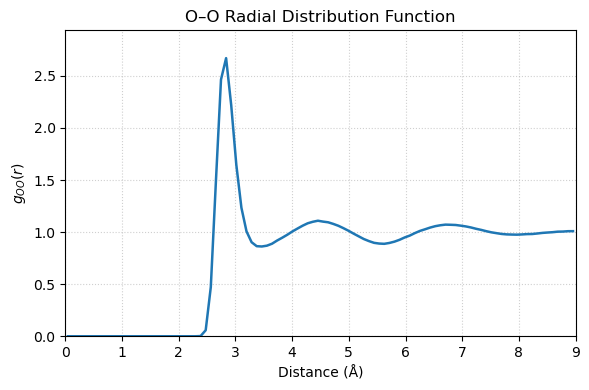

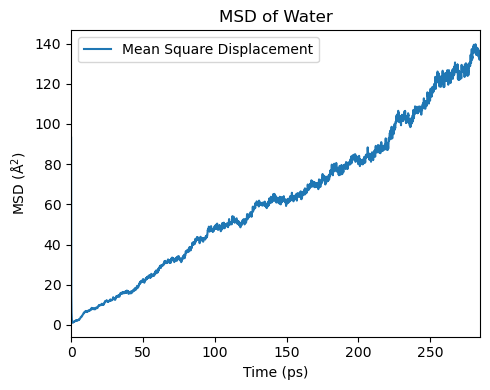

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- File names ---
rdf_file = "./rdf.out"
msd_file = "./water_msd.out" 
# ------------------

# --- Read RDF file and find the last block header ---
with open(rdf_file, "r") as fh:
    lines = fh.readlines()

blocks = []  # stores (start_line_index, nbins, timestep)
for i, ln in enumerate(lines):
    if ln.startswith("#"):
        continue  # skip comments
    toks = ln.split()
    if len(toks) == 2 and toks[0].isdigit() and toks[1].isdigit():
        ts, nbins = map(int, toks)
        blocks.append((i + 1, nbins, ts))

if not blocks:
    raise ValueError("No timestep/nbins header found in RDF file.")

# Select the last recorded block
start, nbins, last_ts = blocks[-1]

# --- Load exactly nbins data rows ---
rdf_block = [
    [float(x) for x in ln.split()]
    for ln in lines[start : start + nbins]
    if ln.strip() and not ln.startswith("#")
]

data = np.asarray(rdf_block)

# Columns: 0 = bin index, 1 = r, 2 = g_OO
r = data[:, 1]
g_OO = data[:, 2]

# --- Plot g_OO(r) ---
plt.figure(figsize=(6, 4))
plt.plot(r, g_OO, lw=1.8)
plt.xlabel("Distance (Å)")
plt.ylabel(r"$g_{OO}(r)$")
plt.title("O–O Radial Distribution Function")
plt.xlim(0, 9)
plt.ylim(0, g_OO.max() * 1.1)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- MSD -------------------------------------------------------
df_msd = pd.read_csv(msd_file, sep='\s+', comment="#", header=None)

# convert both columns to NumPy arrays
time_ps = (df_msd[0] / 1e3).to_numpy()   # fs → ps
msd_aa2  = df_msd[4].to_numpy()

plt.figure(figsize=(5, 4))
plt.plot(time_ps, msd_aa2, label="Mean Square Displacement")
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD (Å$^{2}$)")
plt.title("MSD of Water")
plt.xlim(0, time_ps[-1])
plt.legend()
plt.tight_layout()
plt.show()


## What to look for

* **RDF:** The first sharp peak at ≈ 2.8 Å reflects the average O–O distance (first solvation shell); subsequent peaks trace the differnt solvatoin shells of  liquid water.

* **MSD:** Formally the self-diffusion coefficient  

$$
D \;=\; \frac{1}{6}\,\frac{\mathrm d}{\mathrm dt}\bigl\langle r^{2}(t)\bigr\rangle
$$

should be obtained from a trajectory propagated in the **NVE (micro-canonical)** ensemble *after* the system has been equilibrated.  
Running without a thermostat or barostat ensures that the dynamics obey Newton’s equations unperturbed—thermostats can inject or remove momentum and thus distort time-correlation functions, while barostats rescale coordinates and momenta, both of which bias \(D\).

&nbsp;↳ *Here we keep the simulation in the NPT ensemble purely for demonstration and convenience.*  
The MSD curve still shows the qualitative crossover from the short-time caging regime to long-time diffusion, but the absolute value of \(D\) should be treated as illustrative rather than publication-ready.


### MB-nrg energy decomposition & basic thermodynamic checks  

This section does two things:

1. **Many-body PIP energies** – plots the 1-, 2- and 3-body polynomial interaction energies (`E1b_PIP`, `E2b_PIP`, `E3b_PIP`) written by MBX.  
2. **Time-series monitors** – shows how temperature, potential energy, density and pressure evolve, so you can confirm the system has reached steady state.

Replace the file paths in the first code cell (`mbnrg_file`, `thermo_file`) with the names in your run directory and execute once.  
*All time axes are converted from femtoseconds to picoseconds for readability.*


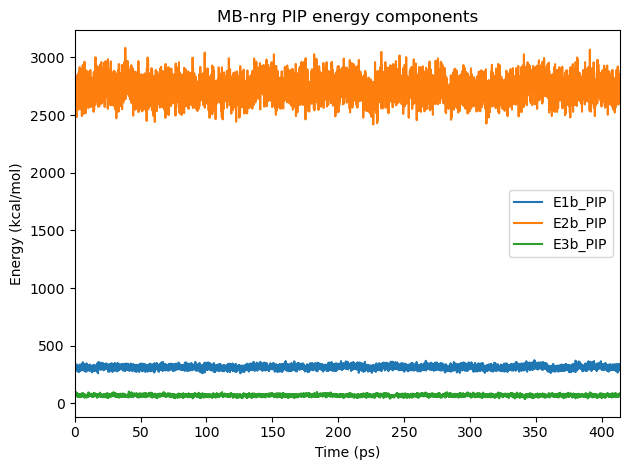

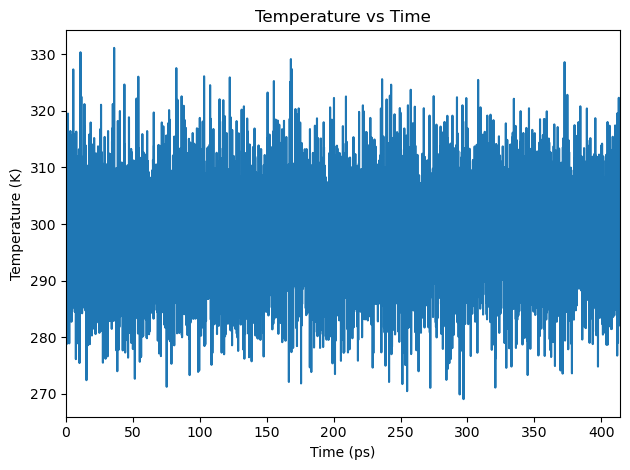

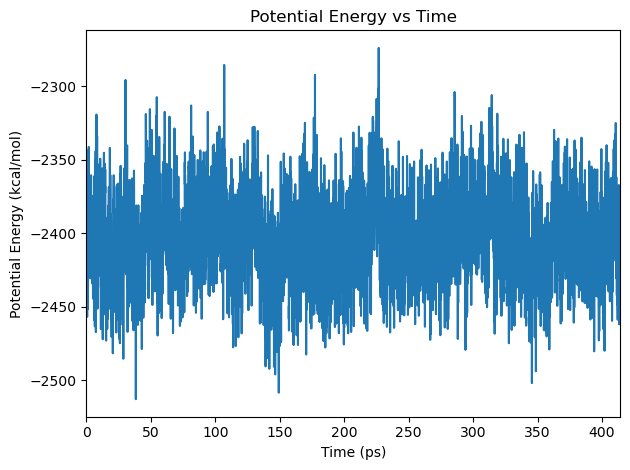

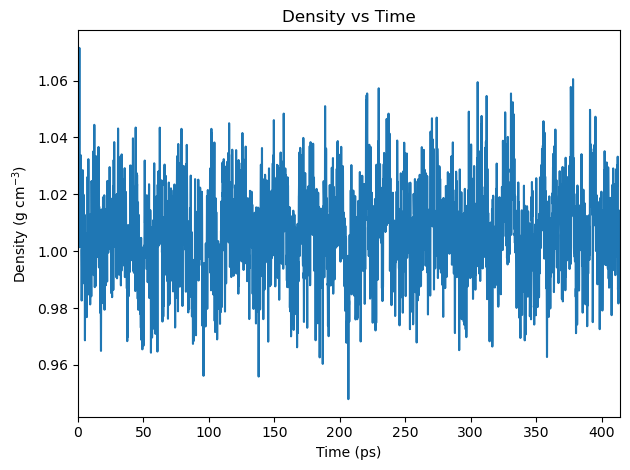

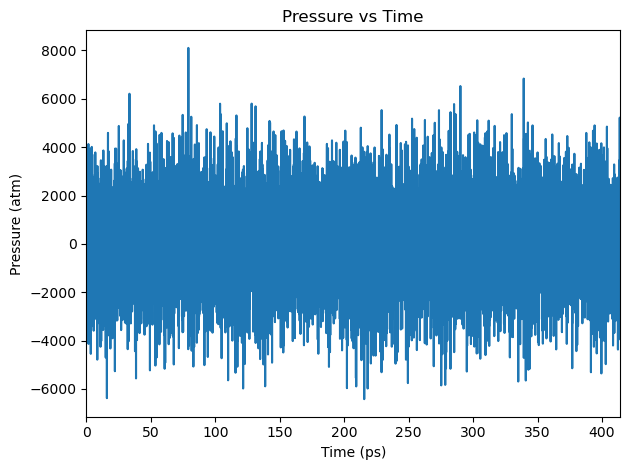

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# ─── file names to edit ───────────────────────────────────────────────
mbnrg_file  = "./mbx_thermo.out"
thermo_file = "./thermo.out"
# ──────────────────────────────────────────────────────────────────────

# --------------------  MB-nrg PIP energies  ---------------------------
def plot_MBnrg(file_path):
    df = pd.read_csv(file_path, sep=r'\s+', comment='#', header=None)
    df = df.iloc[:, :4]
    df.columns = ['time', 'e1b', 'e2b', 'e3b']

    # convert to NumPy arrays
    t_ps = (df['time'] / 1e3).to_numpy()
    e1   = df['e1b'].to_numpy()
    e2   = df['e2b'].to_numpy()
    e3   = df['e3b'].to_numpy()

    plt.figure()
    plt.plot(t_ps, e1, label='E1b_PIP')
    plt.plot(t_ps, e2, label='E2b_PIP')
    plt.plot(t_ps, e3, label='E3b_PIP')
    plt.xlabel('Time (ps)')
    plt.ylabel('Energy (kcal/mol)')
    plt.title('MB-nrg PIP energy components')
    plt.xlim(0, t_ps[-1])
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_MBnrg(mbnrg_file)


# --------------------  Thermodynamic series  --------------------------
required_cols = ['time', 'temp', 'pe', 'density', 'press']

def load_data(path):
    df = pd.read_csv(
        path,
        sep=r'\s+',
        comment='#',
        header=None,
        usecols=[1, 2, 5, 7, 15]
    )
    df.columns = required_cols
    df['time'] /= 1e3
    return df

def plot_time_vs_column(df, col, y_label, y_unit):
    # convert both axes to NumPy
    t = df['time'].to_numpy()
    y = df[col].to_numpy()

    plt.figure()
    plt.plot(t, y)
    plt.xlabel('Time (ps)')
    plt.ylabel(f'{y_label} ({y_unit})')
    plt.title(f'{y_label} vs Time')
    plt.xlim(0, t[-1])
    plt.tight_layout()
    plt.show()

thermo_df = load_data(thermo_file)

plot_time_vs_column(thermo_df, 'temp',    'Temperature',      'K')
plot_time_vs_column(thermo_df, 'pe',      'Potential Energy', 'kcal/mol')
plot_time_vs_column(thermo_df, 'density', 'Density',          'g cm$^{-3}$')
plot_time_vs_column(thermo_df, 'press',   'Pressure',         'atm')
